In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [50]:
min_date = "2022_12_7"
imbalanced = True

results = []
names = []
for result_file in os.listdir("results"):
    if result_file > min_date:
        if (imbalanced and "imbalance" in result_file) or (not imbalanced and not "imbalance" in result_file):
            with open(os.path.join("results", result_file), "r") as f:
                results += [json.load(f)]
                name = result_file.split("_")[-1][:-5]
                if "imbalance" in name: name = name[:-11]
                names += [name]

In [51]:
def smooth_curve(values, mom=0.7):
    new_values = []
    last_v = None
    for v in values:
        v = v if last_v is None else last_v * mom + (1-mom) * v
        last_v = v
        new_values += [v]
    return new_values


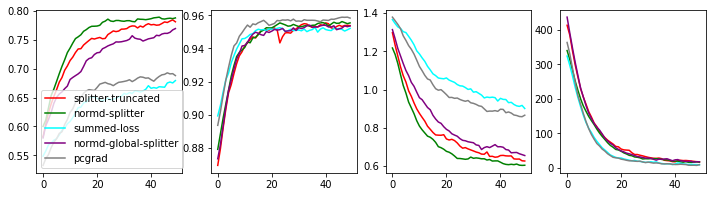

In [52]:
keys = ["test_acc_L", "test_acc_R", "train_loss_L", "train_loss_R"]
colors = ["red", "green", "cyan", "purple", "gray", "brown", "pink"]
_, ax_list = plt.subplots(1,len(keys), sharey="none", sharex="all", figsize=(len(keys)*3, 3))


for k in range(len(results)):
    for i, key in enumerate(keys):

        ax_list[i].plot(smooth_curve(results[k][key]), color=colors[k], label=names[k])


for i, key in enumerate(keys):
    if not imbalanced:
        if "acc" in key:
            ax_list[i].set_ylim([0.8,0.97])
        if "loss" in key:
            ax_list[i].set_ylim([0.,0.2])

ax_list[0].legend()